In [1]:
from utils import WebSegmenter,visualize_graph,get_summary
import pandas as pd
import pprint
import seaborn as sns
from datetime import datetime
import pickle
from pprint import pprint
import string

# Support functions

In [2]:
def get_data_from_graph(graph):
    return list(graph.nodes(data=True))

In [3]:
def get_text_from_graph(graph_data):
    txt = ''
    for el in graph_data:
        if 'payload' in el[1]:
            if el[1]['payload']:
                txt += el[1]['payload'].get('text')
                if not txt.endswith('\n'):
                      txt += '\n'
        
        if 'link_meta' in el[1]:
            if el[1]['link_meta'] is not None:
                if 'text_payload' in el[1]['link_meta'] and el[1]['link_meta'].get('text_payload'):
                    for txt_tmp in el[1]['link_meta']['text_payload']:
                        if not txt_tmp.endswith('\n'):
                            txt_tmp += '\n'
                        if not txt.endswith(txt_tmp):
                            txt += txt_tmp
    return txt

In [4]:
def replace_end_of_line_and_duplicate_by_whitespace(txt):
    #replace punctuation by whitespace with a regex
    txt = txt.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    txt = txt.replace('\n',' ')
    txt = txt.replace('\t',' ')
    txt = txt.replace('\r',' ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')
    return txt

In [5]:
def lower_case_and_convert_txt_to_tokens_set(txt):
    txt = txt.lower()
    txt = txt.split(' ')
    txt = set(txt)
    return txt

In [6]:
def clean_txt(txt):
    return replace_end_of_line_and_duplicate_by_whitespace(txt)

In [7]:
def txt_to_set(txt):
    txt = replace_end_of_line_and_duplicate_by_whitespace(txt)
    txt = lower_case_and_convert_txt_to_tokens_set(txt)
    return txt

In [8]:
def jaccard_similarity(txt1, txt2):
    intersection = len(txt1.intersection(txt2))
    union = len(txt1.union(txt2))
    return intersection / union

In [30]:
def set_difference(txt1, txt2):
    return txt1.difference(txt2)

# Load data

On a sample of 1K scraped website, 

In [9]:
pdf = pickle.load(open('PE_relevant_sample_2023_05_23_with_analysis.pkl', 'rb'))
pdf = pdf[pdf['graph_size'] > 250]
pdf.head()

,url,content,graph,any_graph,graph_size
13,http://seamfix.com,\n ; Seamfix – People & Software Development C...,"(d07d6b99955b3348ec7ac7ed67d75832e041b876, 752...",1,352
14,http://tailwindapp.com,; Tailwind Social Media & Email Marketing To...,"(3984cbdd5712a6f4ed35f54bb65151b821186804, 698...",1,310
16,http://yoappstore.com,\n ; eCommerce App Development Company | Creat...,"(db3d682260e9e7d55b4cd1dd3c8a2638274d4ad8, f35...",1,303
22,http://www.aldautomotive.co.uk,\n ; \r\n\tCompany Car Leasing & Vehicle Leasi...,"(3d98641c2312d3d2b9fae70becade184316941dc, 7ad...",1,304
26,http://www.sauter-personal.de,"\n ; Die Jobbörse mit aktuellen Jobprofilen, J...","(698f1cae7b3208b2df9856db2d951ddddc7022bf, 1bb...",1,260


## Extract and clean texts

In [10]:
pdf['graph_data'] = pdf['graph'].apply(get_data_from_graph)
pdf['graph_text'] = pdf['graph_data'].apply(get_text_from_graph)
pdf['graph_text_clean'] = pdf['graph_text'].apply(clean_txt)
pdf['graph_text_clean_set'] = pdf['graph_text_clean'].apply(txt_to_set)

In [11]:
pdf['content_text_clean'] = pdf['content'].apply(clean_txt)
pdf['content_text_clean_set'] = pdf['content_text_clean'].apply(txt_to_set)

In [12]:
pdf[['content_text_clean','graph_text_clean']].head()

,content_text_clean,graph_text_clean
13,Seamfix – People Software Development Company...,Solutions Verification Suite Enrolment Suite ...
14,Tailwind Social Media Email Marketing Tool Pl...,Please Wait Connecting your Pinterest account ...
16,eCommerce App Development Company Create mobi...,info yoappstore com 91 74156 64456 Home About ...
22,Company Car Leasing Vehicle Leasing ALD Auto...,Apps ALD websites Algeria Austria Belarus Bel...
26,Die Jobbörse mit aktuellen Jobprofilen Jobs u...,Für Bewerber Jobsuche Portal Initiativbewerbu...


## Length difference

In [13]:
pdf['content_text_clean_size'] = pdf['content_text_clean'].apply(len)
pdf['graph_text_clean_size'] = pdf['graph_text_clean'].apply(len)

In [14]:
pdf[['content_text_clean_size', 'graph_text_clean_size']].corr(method='pearson')

,content_text_clean_size,graph_text_clean_size
content_text_clean_size,1.000000,0.974188
graph_text_clean_size,0.974188,1.000000


In [15]:
pdf[['content_text_clean_size', 'graph_text_clean_size']].corr(method='spearman')

,content_text_clean_size,graph_text_clean_size
content_text_clean_size,1.000000,0.936507
graph_text_clean_size,0.936507,1.000000


In [16]:
pdf[['content_text_clean_size', 'graph_text_clean_size']].corr(method='kendall')

,content_text_clean_size,graph_text_clean_size
content_text_clean_size,1.000000,0.849794
graph_text_clean_size,0.849794,1.000000


<Axes: xlabel='content_text_clean_size', ylabel='graph_text_clean_size'>

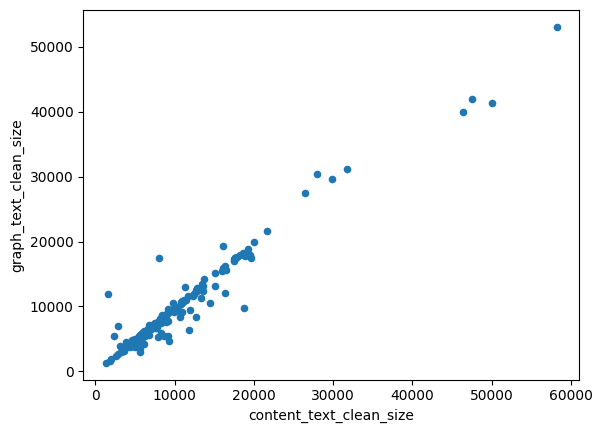

In [17]:
pdf.plot.scatter(x='content_text_clean_size', y='graph_text_clean_size')

In [ ]:
# Display the the rows where the absolute relative ratio of the graph text size over the content text size is greater than 1.5
pdf['ratio'] = 1 - pdf['graph_text_clean_size'] / pdf['content_text_clean_size']
pdf['ratio'] = pdf['ratio'].abs()
for r in pdf[pdf['ratio'] > .5].iterrows():
    print(r[0])
    print(r[1]['url'])
    pprint(r[1]['content_text_clean'])
    print('\n----------------\n') 
    pprint(r[1]['graph_text_clean'])
    print(r[1]['ratio'])
    print('\n\n\n\n')


## Token set size difference

In [35]:
pdf['content_text_clean_set_size'] = pdf['content_text_clean_set'].apply(len)
pdf['graph_text_clean_set_size'] = pdf['graph_text_clean_set'].apply(len)

In [37]:
pdf[['content_text_clean_set_size', 'graph_text_clean_set_size']].corr(method='pearson')

,content_text_clean_set_size,graph_text_clean_set_size
content_text_clean_set_size,1.000000,0.986521
graph_text_clean_set_size,0.986521,1.000000


In [38]:
pdf[['content_text_clean_set_size', 'graph_text_clean_set_size']].corr(method='spearman')

,content_text_clean_set_size,graph_text_clean_set_size
content_text_clean_set_size,1.000000,0.974968
graph_text_clean_set_size,0.974968,1.000000


In [39]:
pdf[['content_text_clean_set_size', 'graph_text_clean_set_size']].corr(method='kendall')

,content_text_clean_set_size,graph_text_clean_set_size
content_text_clean_set_size,1.000000,0.928571
graph_text_clean_set_size,0.928571,1.000000


<Axes: xlabel='content_text_clean_set_size', ylabel='graph_text_clean_set_size'>

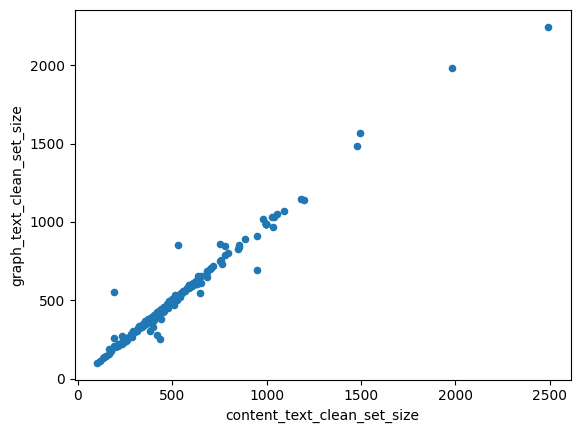

In [40]:
pdf.plot.scatter(x='content_text_clean_set_size', y='graph_text_clean_set_size')

In [ ]:
# samples where the graph text set size is greater than the content text set size by more than 50%
pdf['ratio'] = 1 - pdf['graph_text_clean_set_size'] / pdf['content_text_clean_set_size']
pdf['ratio'] = pdf['ratio'].abs()
for r in pdf[pdf['ratio'] > .5].iterrows():
    print(r[0])
    print(r[1]['url'])
    pprint(r[1]['content_text_clean'])
    print('\n----------------\n') 
    pprint(r[1]['graph_text_clean'])
    print(r[1]['ratio'])
    print('\n\n\n\n')

## Jaccard similarity of tokens set

In [27]:
# Jaccard similarity of tokens set
pdf['token_set_jaccard_similarity'] = pdf.apply(lambda x: jaccard_similarity(x['content_text_clean_set'], x['graph_text_clean_set']), axis=1)

<Axes: xlabel='token_set_jaccard_similarity', ylabel='Count'>

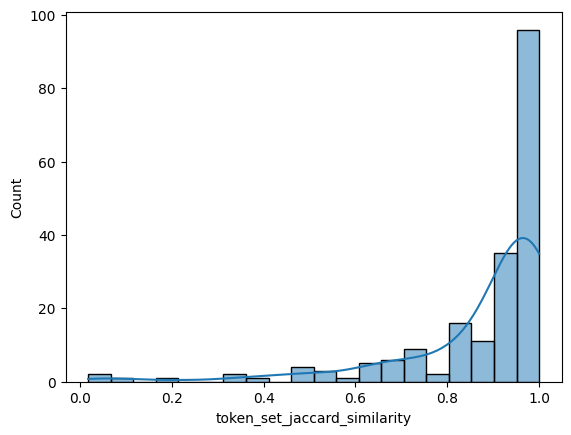

In [28]:
sns.histplot(pdf['token_set_jaccard_similarity'], kde=True)

In [ ]:
#sample with a jaccard similarity under 0.8
for r in pdf[pdf['token_set_jaccard_similarity'] < .8].iterrows():
    print(r[0])
    print(r[1]['url'])
    print('\n----------------Content - Graph----------------') 
    pprint(set_difference(r[1]['content_text_clean_set'], r[1]['graph_text_clean_set']))
    print('\n----------------Graph - Content----------------')
    pprint(set_difference(r[1]['graph_text_clean_set'], r[1]['content_text_clean_set']))
    pprint(r[1]['content_text_clean'])
    print('\n----------------\n') 
    pprint(r[1]['graph_text_clean'])
    print(r[1]['token_set_jaccard_similarity'])
    print('\n\n\n\n')

# Experiments

In [23]:
websegmenter = WebSegmenter(url='https://www.patsnap.com/') #https://www.patsnap.com/ http://kumo.ai
websegmenter.run()

In [28]:
pdf = pd.read_csv('PE_relevant_sample_2023_05_23.csv')
pdf = pickle.load(open('PE_relevant_sample_2023_05_23_with_analysis.pkl', 'rb'))
pdf.head()

type(pdf['graph'][0])


networkx.classes.digraph.DiGraph

In [24]:
graph_data = list(websegmenter.graph.nodes(data=True))

In [25]:
graph_data

[('ba99e5176271ffecb5c59c9ba043e67a7103504e',
  {'element_type': 'div',
   'class': "['fixed', 'top-0', 'left-0', 'w-full', 'bg-white', 'z-50']",
   'payload': None,
   'link_meta': None}),
 ('456b89893d2433db83af1e28c0649f070a6ae5cd',
  {'element_type': 'div',
   'name_count': 3,
   'item_index': 1,
   'class': 'mx-auto_max-w-[1280px]_h-full_flex_items-center_justify-between',
   'payload': None,
   'link_meta': None}),
 ('4e355f4434d7490705b37195439383ec78fe9ffd',
  {'element_type': 'ul',
   'name_count': 0,
   'item_index': 2,
   'class': 'flex_items-center_h-full',
   'payload': None,
   'link_meta': None}),
 ('a82752648b9dcbdd1a5ddb3d567f3974c935818a',
  {'element_type': 'a',
   'name_count': 0,
   'item_index': 3,
   'class': 'mr-12',
   'payload': {'href': 'https://www.patsnap.com/', 'text': ''},
   'link_meta': {'href': 'https://www.patsnap.com/', 'text_payload': []}}),
 ('aec7a625020a73d210b52cba1c42363e628632d9',
  {'element_type': 'li',
   'name_count': 0,
   'item_index': 4

In [6]:
websegmenter.search('Benefits')

[('86f3108012c47c5730cf14e9e72d725c27da507a',
  {'label': 'Benefits',
   'score': 17,
   'to_filter': False,
   'item_class': 'has_grid'})]

In [7]:
node_id = '86f3108012c47c5730cf14e9e72d725c27da507a'
node_summary = websegmenter.summarize(node_id=node_id)
pprint(node_summary,sort_dicts=False)

{'id': '86f3108012c47c5730cf14e9e72d725c27da507a',
 'content': [{'type': 'grid',
              'payload': [{'type': 'grid_item',
                           'payload': [{'type': 'atom',
                                        'payload': 'We automate all major '
                                                   'steps in the ML lifecycle '
                                                   'from raw data ingestion to '
                                                   'sustained production '
                                                   'deployment'},
                                       {'type': 'atom',
                                        'payload': 'End to end predictive '
                                                   'analytics automation'}],
                           'index': 19},
                          {'type': 'grid_item',
                           'payload': [{'type': 'atom',
                                        'payload': 'Query the future in our '
     

In [18]:
def get_text_from_graph(graph_data):
    txt = ''
    for el in graph_data:
        if 'payload' in el[1]:
            if el[1]['payload']:
                txt += el[1]['payload'].get('text')
                if not txt.endswith('\n'):
                      txt += '\n'
        
        if 'link_meta' in el[1]:
            if el[1]['link_meta'] is not None:
                if 'text_payload' in el[1]['link_meta'] and el[1]['link_meta'].get('text_payload'):
                    for txt_tmp in el[1]['link_meta']['text_payload']:
                        if not txt_tmp.endswith('\n'):
                            txt_tmp += '\n'
                        if not txt.endswith(txt_tmp):
                            txt += txt_tmp
    return txt

In [16]:
txt = ''
for el in graph_data:

    # if 'text' in el[1]:
    #     if el[1]['text']:
    #         txt += el[1]['text']
    #         txt += '\n'

    if 'payload' in el[1]:
        if el[1]['payload']:
            txt += el[1]['payload'].get('text')
            txt += '\n'
    
    if 'link_meta' in el[1]:
        if el[1]['link_meta'] is not None:
            if 'text_payload' in el[1]['link_meta'] and el[1]['link_meta'].get('text_payload'):
                txt_tmp = ' '.join(el[1]['link_meta']['text_payload'])
                txt_tmp += '\n'
                if not txt.endswith(txt_tmp):
                    txt += txt_tmp
            


In [ ]:
print(get_text_from_graph(graph_data))

In [ ]:
pdf[1].apply(lambda x: x['class'])